In [1]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
os.chdir("DiffusionCLIP")
from diffusionclip import DiffusionCLIP

/env/default/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import yaml
from pathlib import Path
from PIL import Image

from main import dict2namespace

In [4]:
device = 'cuda'

None is loaded.
checkpoint/traffic_sign_rusty_FT_traffic_sign_traffic_sign_rusty_t301_ninv40_ngen6_id0.0_l11.0_lr8e-06_rusty_traffic_sign_with_faded_paint-9.pth is loaded.


Inversion process :  98% 39/40 [00:03<00:00, 11.11it/s]


Sampling type: DDIM with eta 0.0,  Steps: 12/301
Uniform skip type


Generative process 0: 100% 12/12 [00:01<00:00, 11.13it/s]


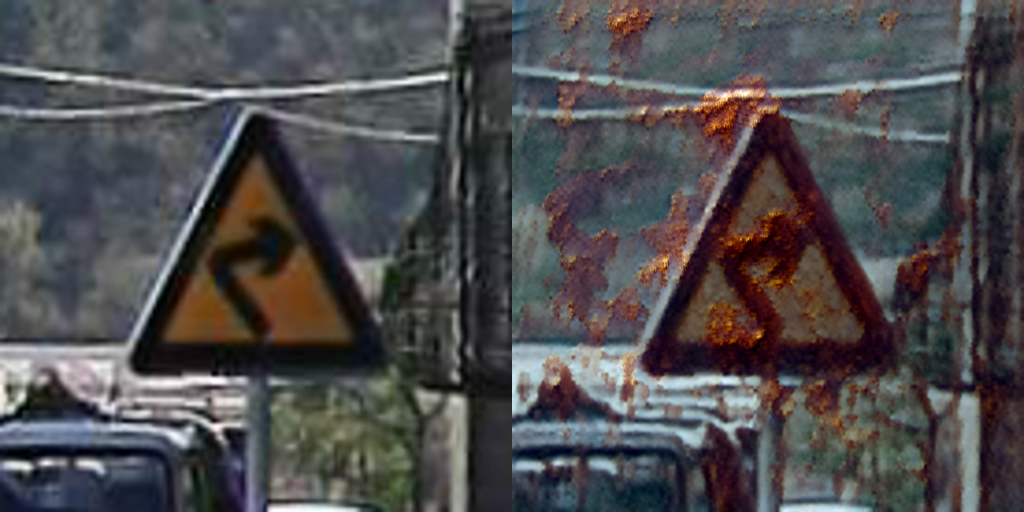

In [14]:
img_path = './data/traffic_Data/TEST/038_1_0002_1_j.png'
img_name = Path(img_path).name

edit_type = 'rusty'  # ['night', 'rainy', 'foggy', 'snowy', 'rusty', 'vines']
degree_of_change = 1 # [min:0.0, max:1.0]

t_0 = 301
pretrained_model_path = './pretrained/512x512_diffusion.pt'

# Finetuned model
fine_tuned_ckpt_dir = Path('./checkpoint')
fine_tuned_epoch = 9
fine_tuned_ckpt_map = {
    'night': fine_tuned_ckpt_dir / f'traffic_sign_night_FT_traffic_sign_traffic_sign_night_t{t_0}_ninv40_ngen6_id0.0_l11.0_lr8e-06_traffic_sign_in_darkness-{fine_tuned_epoch}.pth',
    'rainy': fine_tuned_ckpt_dir / f'traffic_sign_rainy_FT_traffic_sign_traffic_sign_rainy_t{t_0}_ninv40_ngen6_id0.0_l11.0_lr8e-06_traffic_sign_during_rainy_weather-{fine_tuned_epoch}.pth',
    'foggy': fine_tuned_ckpt_dir / f'traffic_sign_foggy_FT_traffic_sign_traffic_sign_foggy_t{t_0}_ninv40_ngen6_id0.0_l11.0_lr8e-06_traffic_sign_in_dense_fog_-{fine_tuned_epoch}.pth',
    'snowy': fine_tuned_ckpt_dir / f'traffic_sign_snowy_FT_traffic_sign_traffic_sign_snowy_t{t_0}_ninv40_ngen6_id0.0_l11.0_lr8e-06_traffic_sign_in_snowy_weather-{fine_tuned_epoch}.pth',
    'rusty': fine_tuned_ckpt_dir / f'traffic_sign_rusty_FT_traffic_sign_traffic_sign_rusty_t{t_0}_ninv40_ngen6_id0.0_l11.0_lr8e-06_rusty_traffic_sign_with_faded_paint-{fine_tuned_epoch}.pth',
    'vines': fine_tuned_ckpt_dir / f'traffic_sign_vines_FT_traffic_sign_traffic_sign_vines_t{t_0}_ninv40_ngen6_id0.0_l11.0_lr8e-06_traffic_sign_overgrown_with_vines-{fine_tuned_epoch}.pth',
}

fine_tuned_ckpt = str(fine_tuned_ckpt_map[edit_type])

exp_dir = f'runs/traffic_sign_test_{edit_type}_{img_name}'
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40
n_test_step = 12
args_dic = {
    'config': 'imagenet.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0.0,
    'bs_test': 1,
    'model_path': fine_tuned_ckpt,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': 1,
    'align_face': 0,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(exp_dir, f"3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}_{fine_tuned_ckpt.split('/')[-1].replace('.pth','')}.png"))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid
